## Function Definition

In [6]:
import numpy as np
import json
import graphviz
from IPython.display import display, Image

GLOBAL_SEED = 13520157
def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

## Class Definition

In [106]:
class FFNN:
    def __init__(self, n_neuron_each_layer=None, actfn=linear, preweight=None):
        if n_neuron_each_layer is None:
            n_neuron_each_layer = [1, 1]
        self.Wdict = {}
        n_layer = len(n_neuron_each_layer)
        assert n_layer >= 2 # minimum one for input and one for output
        assert callable(actfn)
        self.n_layer = n_layer
        self.n_neuron = n_neuron_each_layer
        self.actfn = actfn
        if preweight is None:
            for i in range(1, n_layer):
                np.random.seed(GLOBAL_SEED+i)
                self.Wdict[f'{i-1}-to-{i}'] = np.random.randn(n_neuron_each_layer[i-1]+1, n_neuron_each_layer[i])
                # print(f'{i-1}-to-{i}: {self.Wdict[f"{i-1}-to-{i}"].shape}')
        else:
            assert len(preweight) == n_layer - 1
            preweight = [np.array(w) for w in preweight]
            for i in range(1, n_layer):
                assert preweight[i-1].shape[0] == n_neuron_each_layer[i-1]+1
                assert preweight[i-1].shape[1] == n_neuron_each_layer[i]
                self.Wdict[f'{i-1}-to-{i}'] = preweight[i-1]
                # print(f'{i-1}-to-{i}: {self.Wdict[f"{i-1}-to-{i}"].shape}')

    def forward(self, data):
        assert data.ndim == 2
        assert data.shape[1] == self.n_neuron[0]
        # add bias
        data = np.hstack((np.ones((data.shape[0], 1)), data))
        for k, v in self.Wdict.items():
            data = self.actfn(data @ v)
            data = np.hstack((np.ones((data.shape[0], 1)), data))
        return data[:, 1:]

    def savetojson(self, filename):
        assert filename.endswith('.json')
        with open(filename, 'w') as f:
            data = {
                "n_neuron_each_layer": self.n_neuron,
                "actfn": self.actfn.__name__,
                "preweight": [v.tolist() for k, v in self.Wdict.items()]
            }
            json.dump(data, f)

    @staticmethod
    def loadfromjson(filename):
        assert filename.endswith('.json')
        with open(filename, 'r') as f:
            data = json.load(f)
            return FFNN(data['n_neuron_each_layer'], eval(data['actfn']), data['preweight'])

    def draw(self):
        graph = graphviz.Digraph(engine='neato')
        graph.attr(rankdir='LR')
        layer_spacing = 3  # Increase this value to increase the space between layers
        node_spacing = 2  # Increase this value to increase the space between nodes
        for i in range(self.n_layer):
            if i != self.n_layer - 1:
                graph.node(f'b_{i}', group=f'cluster_{i}', id=f"bias_{i}", pos=f'{i*layer_spacing},0!')
            for j in range(self.n_neuron[i]):
                graph.node(f'{i}_{j}', group=f'cluster_{i}',  pos=f'{i*layer_spacing},{-(j+1)*node_spacing}!')
        #Edges
        # List of colors to use for the edges
        colors = ['red', 'blue', 'green', 'purple', 'orange',
                  'brown', 'magenta', 'olive', 'navy']
        color_index = 0
        for layer in range(self.n_layer - 1):
            for cur_layer_i in range(-1, self.n_neuron[layer]):
                for next_layer_i in range(self.n_neuron[layer+1]):
                    tgt = f"{layer+1}_{next_layer_i}"
                    if cur_layer_i == -1:
                        src = f"b_{layer}"
                        bias = self.Wdict[f'{layer}-to-{layer+1}'][0,next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{bias:.2f}</td></tr></table>>'
                    else:
                        src = f"{layer}_{cur_layer_i}"
                        # Get the weight value for edge (src, tgt)
                        weight = self.Wdict[f'{layer}-to-{layer+1}'][cur_layer_i+1, next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{weight:.2f}</td></tr></table>>'
                    color = colors[color_index % len(colors)]
                    color_index += 1
                    graph.edge(src, tgt, label=label, color=color, fontcolor=color)

        graph.format = 'png'
        display(Image(graph.render('FFNN Graph')))


{'0-to-1': array([[ 0.13889887, -0.85025258, -0.36157663],
       [-1.0044386 , -2.23139466,  1.20277967],
       [-0.21897616, -1.02170888,  1.0741361 ],
       [-0.17002151,  0.38782041, -2.24239095],
       [-1.26586104,  0.58447755,  0.67430682],
       [ 2.54592319, -0.52195368, -0.03160166]]), '1-to-2': array([[ 1.06090228,  0.5674051 , -0.05358699, -0.04888264],
       [-0.37501585,  0.16348989, -1.80287303, -0.36187672],
       [ 0.53232631, -1.42174744,  0.18456336,  0.32508726],
       [ 0.08702599,  1.16698226, -1.12128334, -0.11917016]]), '2-to-3': array([[ 0.00286354,  0.52132826],
       [ 0.88596511,  1.19094519],
       [-1.88196487,  1.03951444],
       [-0.44711943, -0.44107115],
       [ 0.53332867,  1.02345785]]), '3-to-4': array([[-1.48323984],
       [-1.99400297],
       [ 0.01655514]])}


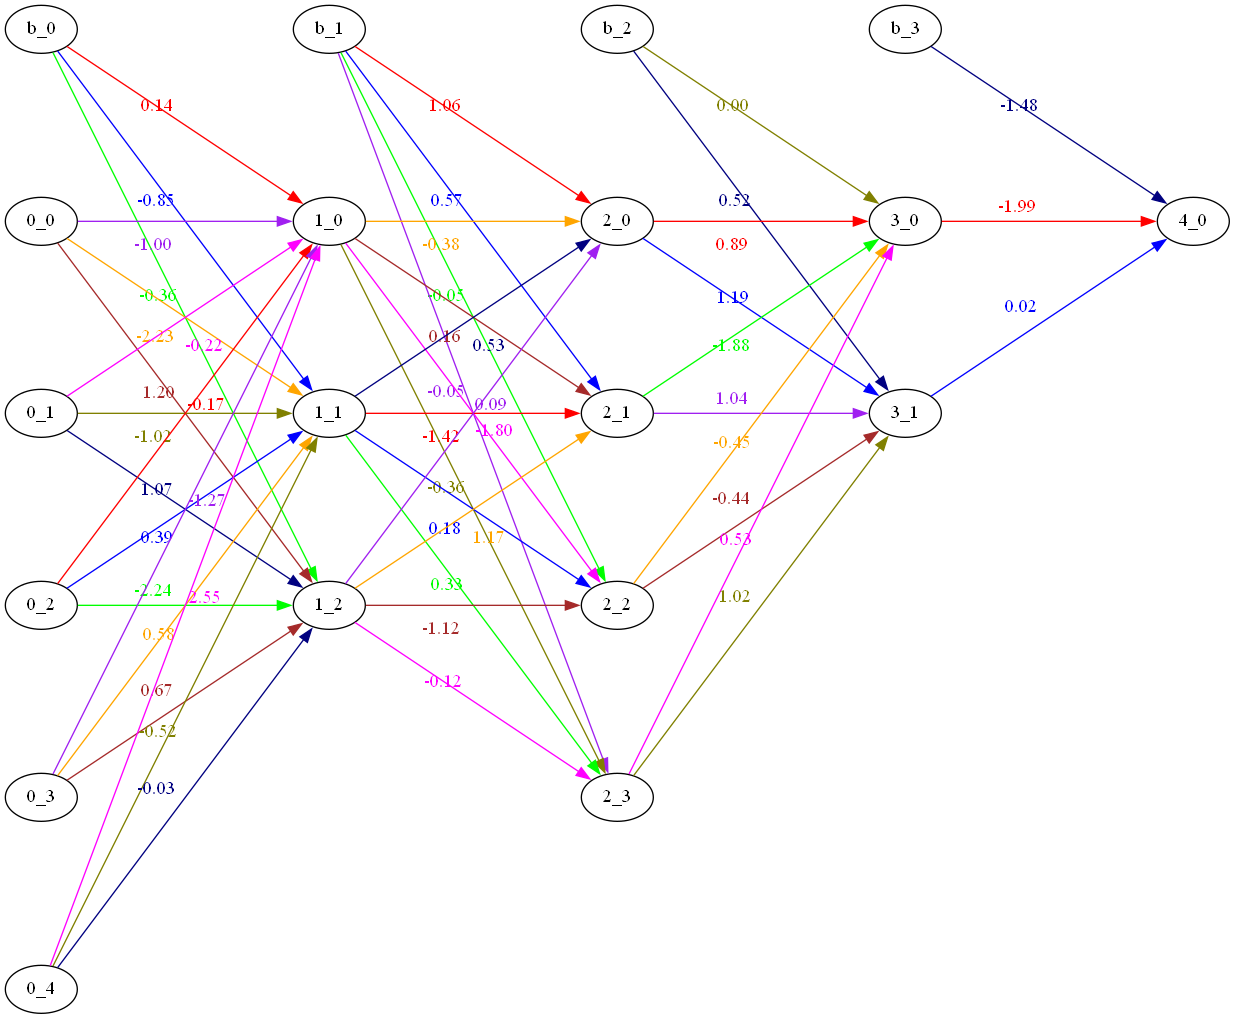

In [110]:
ff = FFNN([3, 4, 4, 2, 1], softmax)
np.random.seed(GLOBAL_SEED)
# print(ff.forward(np.random.randn(10, 4)))
ff.savetojson('test.json')
ff.draw()

In [9]:
ff2 = FFNN.loadfromjson('test.json')
np.random.seed(GLOBAL_SEED)
print(ff2.forward(np.random.randn(10, 4)))

AssertionError: 